<a href="https://colab.research.google.com/github/Gonzalo-Ortega/Stereotypical-Behavior-Classification/blob/main/PyTorch_Testing_Gonzalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from torchvision import torch

import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 7.1 A dataset of tiny images

In [ ]:
data_path = DATA_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/PyTorch-CIFAR10'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 48312616.54it/s]


Extracting /content/gdrive/MyDrive/SBC-Gonzalo/PyTorch-CIFAR10/cifar-10-python.tar.gz to /content/gdrive/MyDrive/SBC-Gonzalo/PyTorch-CIFAR10
Files already downloaded and verified


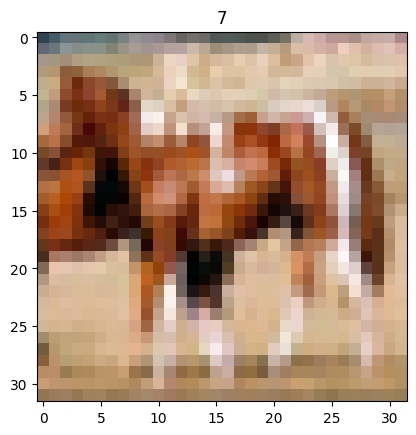

In [ ]:
img, label = cifar10[114]
plt.imshow(img)
plt.title(label)
plt.show()

In [ ]:
# to_tensor = transforms.ToTensor()
# img_t = to_tensor(img)

# Import the dataset transforming it as a tensor:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

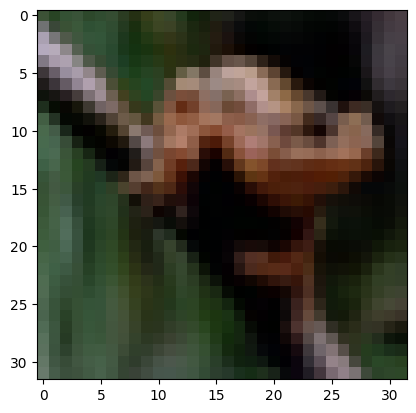

In [ ]:
img_t, _ = tensor_cifar10[5000]

# Permute change the order of the axes:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(imgs.view(3, -1).mean(dim=1),
                                                               imgs.view(3, -1).std(dim=1))
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                           transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(imgs.view(3, -1).mean(dim=1),
                                                                imgs.view(3, -1).std(dim=1))
                                       ]))

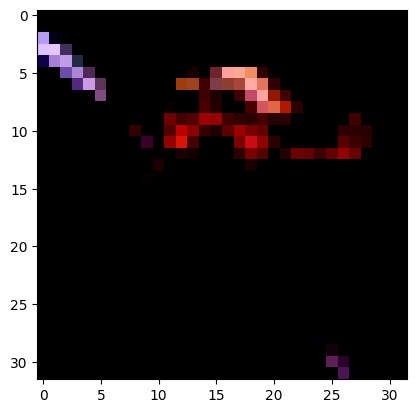

In [ ]:
img_t, _ = transformed_cifar10[5000]

# Permute change the order of the axes:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## 7.2 Distinguishing birds from airplanes

### 7.1.1 Building the dataset

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

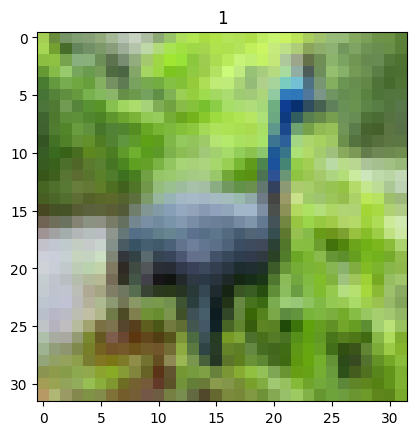

In [ ]:
img, label = cifar2[0]
plt.imshow(img)
plt.title(label)
plt.show()

### 7.2.2 A fully connected model

In [ ]:
n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,  # Input features
        512,   # Hiden layer size ⬇️
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out, # Output classes
    )
    )


### 7.2.4 Respresenting the output as probabilities

In [ ]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1))

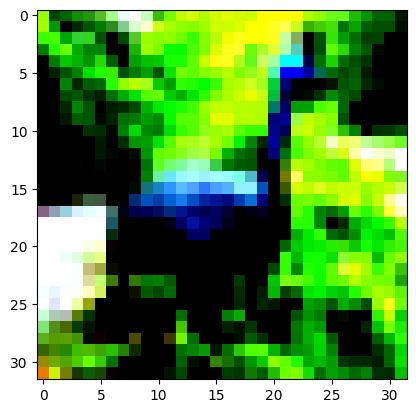

In [ ]:
img, _ = transformed_cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)

In [ ]:
out = model(img_batch)
out

tensor([[0.4353, 0.5647]], grad_fn=<SoftmaxBackward0>)

In [ ]:
_, index = torch.max(out, dim=1)
index

tensor([1])

### 7.2.5 A loss for classifying

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)) # Log makes the log probability calculation numerically stable

In [ ]:
loss = nn.NLLLoss()

In [ ]:
img, label = transformed_cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.9032, grad_fn=<NllLossBackward0>)

### 7.2.6 Tarining the classifier

In [ ]:
train_loader = torch.utils.data.DataLoader(transformed_cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss() # Same as with nn.LogSoftmax and nn.NLLLoss

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.592493
Epoch: 1, Loss: 0.438498
Epoch: 2, Loss: 0.739124
Epoch: 3, Loss: 0.361816
Epoch: 4, Loss: 0.406577
Epoch: 5, Loss: 0.576995
Epoch: 6, Loss: 0.409266
Epoch: 7, Loss: 0.518569
Epoch: 8, Loss: 0.363782
Epoch: 9, Loss: 0.579030
Epoch: 10, Loss: 0.354283
Epoch: 11, Loss: 0.295501
Epoch: 12, Loss: 0.533982
Epoch: 13, Loss: 0.658072
Epoch: 14, Loss: 0.447663
Epoch: 15, Loss: 0.508269
Epoch: 16, Loss: 0.511894
Epoch: 17, Loss: 0.248359
Epoch: 18, Loss: 0.215431
Epoch: 19, Loss: 0.461297
Epoch: 20, Loss: 0.214056
Epoch: 21, Loss: 0.192555
Epoch: 22, Loss: 0.333615
Epoch: 23, Loss: 0.413155
Epoch: 24, Loss: 0.651873
Epoch: 25, Loss: 0.692447
Epoch: 26, Loss: 0.647354
Epoch: 27, Loss: 0.415867
Epoch: 28, Loss: 0.378133
Epoch: 29, Loss: 0.386540
Epoch: 30, Loss: 0.374506
Epoch: 31, Loss: 0.310422
Epoch: 32, Loss: 0.604320
Epoch: 33, Loss: 0.627763
Epoch: 34, Loss: 0.418823
Epoch: 35, Loss: 1.142976
Epoch: 36, Loss: 0.265611
Epoch: 37, Loss: 0.574073
Epoch: 38, Loss: 0.411

In [ ]:
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print(f'Accuracy: {correct / total}')

Accuracy: 0.1081


# 8 Using convolutions to generalize

## 8.1 The case of convolutions

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

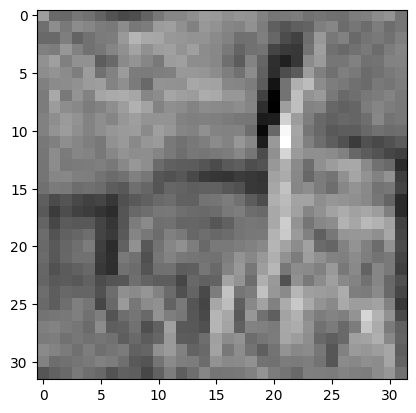

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
with torch.no_grad():
  conv.bias.zero_()
with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

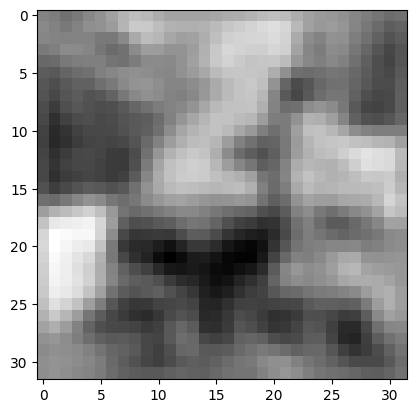

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

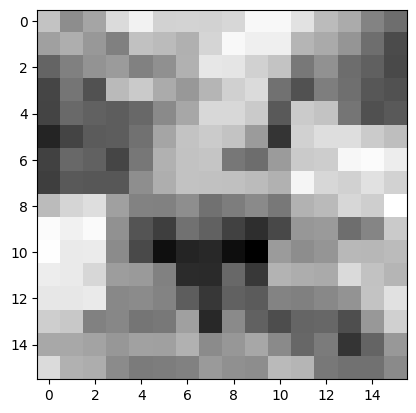

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

## 8.3 Subclassing nn.Module

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8)
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model(img.unsqueeze(0))

tensor([[-0.2076,  0.0683]], grad_fn=<AddmmBackward0>)

## 8.4 Training our convnet

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print(f'{datetime.datetime.now()} \
            Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

2024-04-16 16:12:44.841437             Epoch 1, Training loss 0.5789792752190001
2024-04-16 16:13:27.078652             Epoch 10, Training loss 0.33122658036696684
2024-04-16 16:14:14.914440             Epoch 20, Training loss 0.29751998888459175
2024-04-16 16:15:03.026094             Epoch 30, Training loss 0.2765565840112176
2024-04-16 16:15:49.270118             Epoch 40, Training loss 0.25846850354770184
2024-04-16 16:16:34.918025             Epoch 50, Training loss 0.241762536821092
2024-04-16 16:17:20.881401             Epoch 60, Training loss 0.21983902488544488
2024-04-16 16:18:07.036328             Epoch 70, Training loss 0.20484600828331748
2024-04-16 16:18:52.582698             Epoch 80, Training loss 0.1907642388799388
2024-04-16 16:19:38.962554             Epoch 90, Training loss 0.1740434478232815
2024-04-16 16:20:25.303312             Epoch 100, Training loss 0.1609353938727242


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
  for name, loader in [('train', train_loader), ('val', val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print(f'Accuracy {name}: {correct / total}')

validate(model, train_loader, val_loader)

Accuracy train: 0.9388
Accuracy val: 0.896


### 8.4.2 Saving and loading our model

In [ ]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>